<a href="https://colab.research.google.com/github/DevilsWolf/Basic-scripting/blob/master/IDS_ADVANCED_UPDATED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install shap mlxtend --quiet

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Preprocessing and Feature Engineering
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from scipy.stats.mstats import winsorize
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold, cross_val_score, learning_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Models
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# Evaluation & Explainability
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import cohen_kappa_score, brier_score_loss, roc_auc_score, roc_curve
from mlxtend.evaluate import mcnemar
import shap

# Set plotting style
sns.set_style('whitegrid')
print("Libraries imported and installed successfully.")

Libraries imported and installed successfully.


In [3]:
# ==============================================================================
# Step 1: Mount Google Drive and Load Data
# ==============================================================================
drive.mount('/content/drive')
train_path = '/content/drive/MyDrive/Colab_Data/Train.csv'
test_path = '/content/drive/MyDrive/Colab_Data/Test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
print("\nSuccessfully loaded data from Google Drive.")

Mounted at /content/drive

Successfully loaded data from Google Drive.


In [4]:
# ==============================================================================
# Step 1 & 7: Prepare DataFrames and Split
# The data is already split, so we just assign it to X and y variables.
# Step 1: Encoding is also handled here.
# ==============================================================================
# Separate features (X) and target (y)
X_train_raw = train_df.drop('class', axis=1)
y_train_labels = train_df['class']
X_test_raw = test_df.drop('class', axis=1)
y_test_labels = test_df['class']

# Encode the categorical target variable 'class'
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_labels)
y_test = label_encoder.transform(y_test_labels)
class_names = label_encoder.classes_
print(f"\nTarget classes mapped: {list(zip(range(len(class_names)), class_names))}")


Target classes mapped: [(0, 'Fault'), (1, 'Injection'), (2, 'Masquerade'), (3, 'Normal'), (4, 'Replay')]


In [5]:
# ==============================================================================
# Step 2 & 3: Handle Missing Values and Outliers
# ==============================================================================
print(f"\nMissing values in training data: {X_train_raw.isnull().sum().sum()}") # Step 2

# Step 3: Apply Winsorization to handle outliers
# This caps extreme values at the 1st and 99th percentiles for each feature.
X_train_winsorized = X_train_raw.copy()
for col in X_train_winsorized.columns:
    X_train_winsorized[col] = winsorize(X_train_winsorized[col], limits=[0.01, 0.01])

# Apply the same logic to the test set (though ideally, you'd use the train set's percentile values)
X_test_winsorized = X_test_raw.copy()
for col in X_test_winsorized.columns:
    X_test_winsorized[col] = winsorize(X_test_winsorized[col], limits=[0.01, 0.01])
print("Outliers handled using Winsorization.")


Missing values in training data: 0
Outliers handled using Winsorization.


In [6]:
# ==============================================================================
# Step 4, 5, 6: Feature Selection (using RFE)
# ANOVA/Chi-Square are good, but RFE is a powerful alternative.
# We'll use a fast model like RandomForest for the selection process.
# We aim to select the top 40 features as an example.
# ==============================================================================
print("\nPerforming Recursive Feature Elimination (RFE) to select the best 40 features...")
selector_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
# RFE will recursively remove features and select the best ones.
rfe = RFE(estimator=selector_model, n_features_to_select=40, step=1)
rfe.fit(X_train_winsorized, y_train)

# Get the selected feature names
selected_features = X_train_raw.columns[rfe.support_]
print(f"\nTop 40 features selected by RFE:\n{selected_features.tolist()}")

# Filter the datasets to keep only the selected features
X_train = X_train_winsorized[selected_features]
X_test = X_test_winsorized[selected_features]
print(f"DataFrames filtered to {X_train.shape[1]} features.")


Performing Recursive Feature Elimination (RFE) to select the best 40 features...

Top 40 features selected by RFE:
['time', 'sqNum', 'stnum', 'state_cb', 'sqDiff', 'stDiff', 'timeLastMsg', 'recentChange', 'consistency', 'threePhaseVSum', 'threePhaseCSum', 'threePhaseVMU1', 'MU1VoltageAngleA', 'MU1VoltageAngleB', 'MU1VoltageAngleC', 'threePhaseCurrentMU1', 'MU1CurrentAngleA', 'MU1CurrentAngleC', 'MU1Log', 'MU2VoltageAngleA', 'MU2VoltageAngleB', 'MU2VoltageAngleC', 'threePhaseCMU2', 'MU2CurrentAngleA', 'MU2CurrentAngleB', 'MU2CurrentAngleC', 'MU2Log', 'MU3VoltageAngleA', 'MU3VoltageAngleB', 'threePhaseCMU3', 'MU3CurrentAngleA', 'MU3CurrentAngleB', 'MU3CurrentAngleC', 'threePhaseVMU4', 'MU4VoltageAngleA', 'threePhaseCMU4', 'IED4_iA', 'IED4_iB', 'IED4_iC', 'any_relay']
DataFrames filtered to 40 features.


In [7]:
# ==============================================================================
# Step 8 & 9: Check Label Counts and Handle Class Imbalance with SMOTE
# ==============================================================================
print("\nLabel counts in the training set before balancing:") # Step 8
print(y_train_labels.value_counts())

print("\nApplying SMOTE to handle class imbalance...") # Step 9
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("\nLabel counts after balancing with SMOTE:")
print(pd.Series(y_train_balanced).value_counts())


Label counts in the training set before balancing:
class
Normal        455
Masquerade    397
Injection     101
Replay        100
Fault          41
Name: count, dtype: int64

Applying SMOTE to handle class imbalance...

Label counts after balancing with SMOTE:
0    455
1    455
2    455
3    455
4    455
Name: count, dtype: int64


In [8]:
# ==============================================================================
# Step 10: Apply Scaling (after balancing)
# ==============================================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test) # Use the same scaler fitted on training data
print("\nTraining and testing data have been scaled.")


Training and testing data have been scaled.


In [10]:
# Step 11 & 12: Train Model, Cross-Validation, and Learning Curve
# We'll focus on XGBoost as it's likely to be the best performer.
# ==============================================================================
best_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Step 11: Train on the full balanced training data and time it
print("\n--- Training the final XGBoost model ---")
start_time = time.time()
best_model.fit(X_train_scaled, y_train_balanced)
end_time = time.time()
training_time = end_time - start_time

print(f"Training completed in {training_time:.4f} seconds.")
# Training report (on the balanced training data itself to check for overfitting)
y_train_pred = best_model.predict(X_train_scaled)
print("\nTraining Set Performance Report:")
print(classification_report(y_train_balanced, y_train_pred, target_names=class_names, digits=4))


--- Training the final XGBoost model ---


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:14:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training completed in 9.2654 seconds.

Training Set Performance Report:
              precision    recall  f1-score   support

       Fault     1.0000    1.0000    1.0000       455
   Injection     1.0000    1.0000    1.0000       455
  Masquerade     1.0000    1.0000    1.0000       455
      Normal     1.0000    1.0000    1.0000       455
      Replay     1.0000    1.0000    1.0000       455

    accuracy                         1.0000      2275
   macro avg     1.0000    1.0000    1.0000      2275
weighted avg     1.0000    1.0000    1.0000      2275




--- Performing 10-Fold Cross-Validation ---


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:15:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:15:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:15:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:15:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:15:30] WARNING: /w

Cross-Validation Accuracy Scores: 
[0.9091 0.9091 0.8818 0.8636 0.8624 0.8991 0.9174 0.9174 0.8991 0.8899]
Mean CV Accuracy: 0.8949
Standard Deviation of CV Accuracy: 0.0192


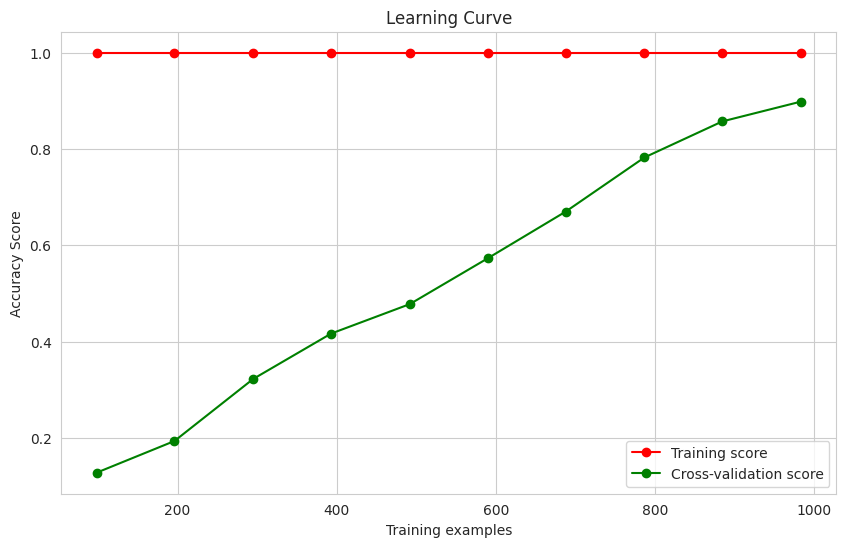

In [11]:
# Step 12: Perform 10-fold Cross-Validation
print("\n--- Performing 10-Fold Cross-Validation ---")
# Create a pipeline to ensure SMOTE is applied correctly within each fold
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
])
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy')

print(f"Cross-Validation Accuracy Scores: \n{np.round(cv_scores, 4)}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation of CV Accuracy: {cv_scores.std():.4f}")

# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=pipeline, X=X_train, y=y_train, cv=cv, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, val_mean, 'o-', color="g", label="Cross-validation score")
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Accuracy Score")
plt.legend(loc="best")
plt.show()


--- Testing the final model ---
Testing completed in 0.0912 seconds.

Test Set Performance Report:
              precision    recall  f1-score   support

       Fault     1.0000    1.0000    1.0000        41
   Injection     1.0000    1.0000    1.0000       101
  Masquerade     0.9925    0.9950    0.9937       397
      Normal     0.9891    1.0000    0.9945       455
      Replay     1.0000    0.9400    0.9691       100

    accuracy                         0.9927      1094
   macro avg     0.9963    0.9870    0.9915      1094
weighted avg     0.9927    0.9927    0.9926      1094

Cohen's Kappa: 0.9892
AUC Score (One-vs-Rest): 0.9995
Brier Score Loss (Multiclass): 0.0021


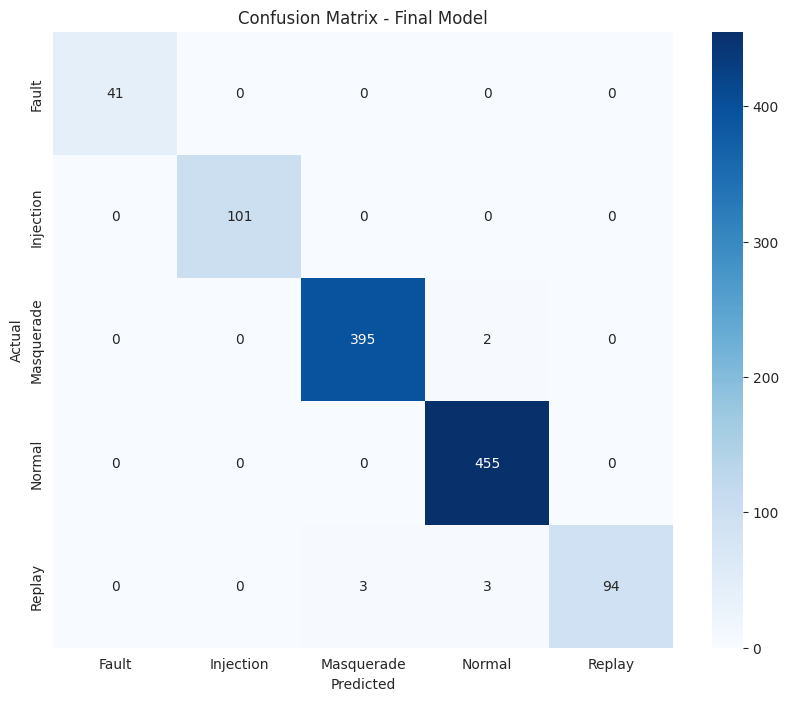

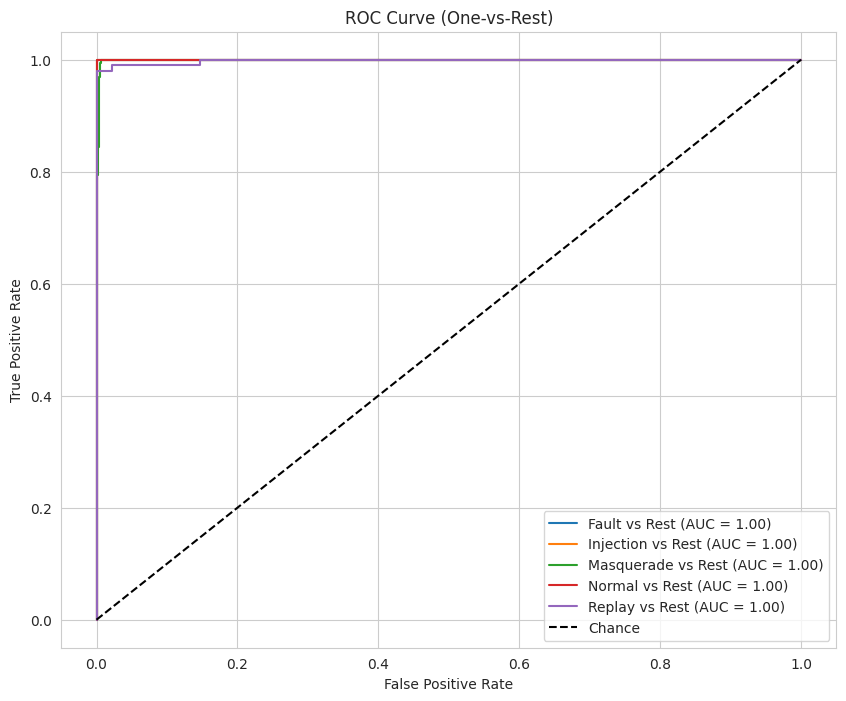

In [13]:
# ==============================================================================
# Step 13, 14, 15: Test Model, Advanced Metrics, and Ensemble
# ==============================================================================
# Import the necessary tools for one-hot encoding and AUC calculation
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import auc

# Step 13: Test the final model
print("\n--- Testing the final model ---")
start_time = time.time()
y_test_pred = best_model.predict(X_test_scaled)
end_time = time.time()
testing_time = end_time - start_time

print(f"Testing completed in {testing_time:.4f} seconds.")
print("\nTest Set Performance Report:")
print(classification_report(y_test, y_test_pred, target_names=class_names, digits=4))

# Additional metrics
kappa = cohen_kappa_score(y_test, y_test_pred)
y_test_proba = best_model.predict_proba(X_test_scaled)

# --- FIX IS HERE ---
# For multiclass Brier score, we need to one-hot encode the true labels.
lb = LabelBinarizer()
y_test_one_hot = lb.fit_transform(y_test)
# Now calculate the Brier score using the one-hot labels and full probabilities
brier = brier_score_loss(y_test_one_hot.ravel(), y_test_proba.ravel())
# ------------------

auc_score = roc_auc_score(y_test, y_test_proba, multi_class='ovr')

print(f"Cohen's Kappa: {kappa:.4f}")
print(f"AUC Score (One-vs-Rest): {auc_score:.4f}")
print(f"Brier Score Loss (Multiclass): {brier:.4f}") # Now this will work

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Final Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ROC Curve (One-vs-Rest)
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_test, y_test_proba[:, i], pos_label=i)
    plt.plot(fpr, tpr, label=f'{class_names[i]} vs Rest (AUC = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend()
plt.show()

In [19]:
# Step 14: McNemar's Test (comparing RF and XGBoost)
print("\n--- McNemar's Test: Comparing RF and XGBoost ---")
# Train a simple RF model on the same data for comparison
rf_comp_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_comp_model.fit(X_train_scaled, y_train_balanced)
y_test_pred_rf = rf_comp_model.predict(X_test_scaled)

# McNemar's test requires a 2x2 contingency table of disagreements
# Create the contingency table
# cell a: both models correct
# cell b: model 1 incorrect, model 2 correct
# cell c: model 1 correct, model 2 incorrect
# cell d: both models incorrect
correct_model1 = (y_test_pred == y_test)
correct_model2 = (y_test_pred_rf == y_test)

n_a = np.sum(correct_model1 & correct_model2)
n_b = np.sum(~correct_model1 & correct_model2)
n_c = np.sum(correct_model1 & ~correct_model2)
n_d = np.sum(~correct_model1 & ~correct_model2)

contingency_table = np.array([[n_a, n_b],
                              [n_c, n_d]])

tb = mcnemar(ary=contingency_table, exact=True)
print(f"McNemar's test p-value: {tb[1]:.4f}")
if tb[1] > 0.05:
    print("Conclusion: There is no significant difference between the XGBoost and RF models (p > 0.05).")
else:
    print("Conclusion: There is a significant difference between the XGBoost and RF models (p <= 0.05).")


--- McNemar's Test: Comparing RF and XGBoost ---
McNemar's test p-value: 0.3750
Conclusion: There is no significant difference between the XGBoost and RF models (p > 0.05).


In [20]:
# Step 15: Ensemble Model (Voting Classifier)
print("\n--- Building a Hybrid Ensemble Model (Voting Classifier) ---")
clf1 = LogisticRegression(max_iter=1000, random_state=42)
clf2 = RandomForestClassifier(n_estimators=50, random_state=42)
clf3 = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

pipe1 = ImbPipeline([('scaler', StandardScaler()), ('clf', clf1)])
pipe2 = ImbPipeline([('scaler', StandardScaler()), ('clf', clf2)])
pipe3 = ImbPipeline([('scaler', StandardScaler()), ('clf', clf3)])

eclf1 = VotingClassifier(estimators=[('lr', pipe1), ('rf', pipe2), ('xgb', pipe3)], voting='soft', weights=[1, 2, 2])
eclf1 = eclf1.fit(X_train_balanced, y_train_balanced)
y_pred_ensemble = eclf1.predict(X_test)

print("Ensemble Model Accuracy:", accuracy_score(y_test, y_pred_ensemble))
print("\nEnsemble Model Classification Report:\n", classification_report(y_test, y_pred_ensemble, target_names=class_names, digits=4))


--- Building a Hybrid Ensemble Model (Voting Classifier) ---


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:24:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Ensemble Model Accuracy: 0.993601462522852

Ensemble Model Classification Report:
               precision    recall  f1-score   support

       Fault     1.0000    1.0000    1.0000        41
   Injection     1.0000    1.0000    1.0000       101
  Masquerade     0.9925    0.9975    0.9950       397
      Normal     0.9913    1.0000    0.9956       455
      Replay     1.0000    0.9400    0.9691       100

    accuracy                         0.9936      1094
   macro avg     0.9968    0.9875    0.9919      1094
weighted avg     0.9936    0.9936    0.9935      1094




--- Explaining the XGBoost model with SHAP ---
Generating SHAP Summary Plot...


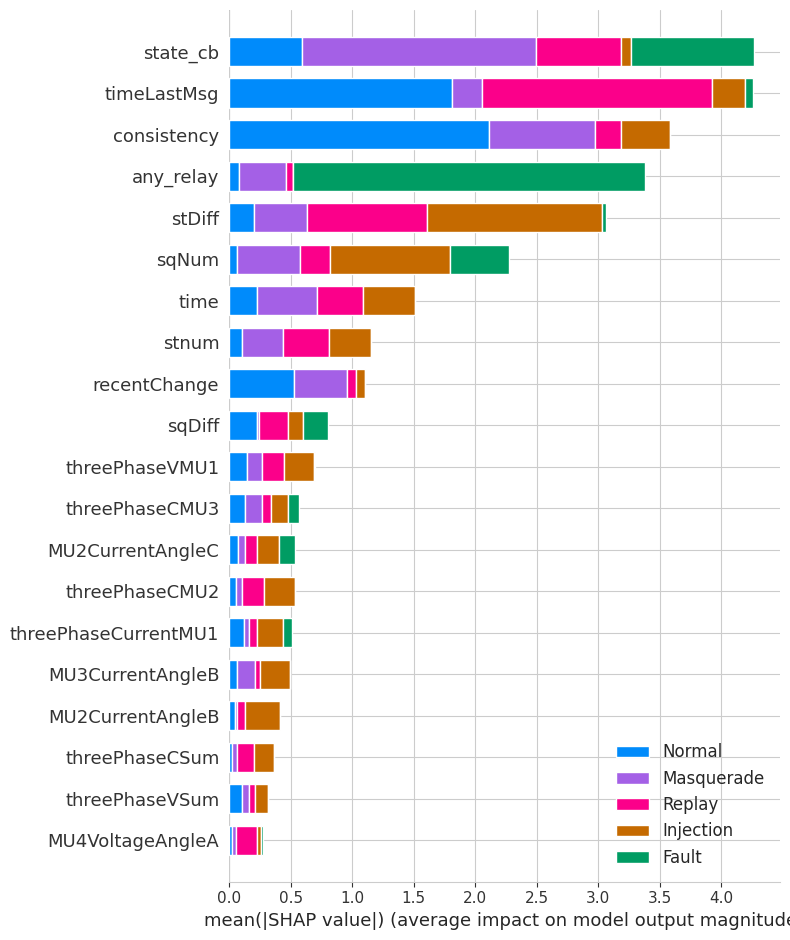

In [21]:
# ==============================================================================
# Step 16: Explain Model Predictions with SHAP
# ==============================================================================
print("\n--- Explaining the XGBoost model with SHAP ---")
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_scaled)

print("Generating SHAP Summary Plot...")
shap.summary_plot(shap_values, X_test, feature_names=selected_features, class_names=class_names, plot_type="bar")
plt.show()